# Polaris Ligand Poses Challenge 2025 - Data Exploration

In [7]:
import polaris as po
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import fastpdb
import datamol as dm
import nglview as nv
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

competition = po.load_competition("asap-discovery/antiviral-ligand-poses-2025")
competition.cache("../data/antiviral-ligand-poses-2025")

[2025-03-09 22:21:38] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=610126;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=635278;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.9).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=52504;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=786453;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

[22:21:38] Copying to destination ../data/antiviral-ligand-poses-2025/data.zarr                        ]8;id=740467;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=686442;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/dataset/_base.py#380\380]8;;\

           For large Zarr archives, this may take a while.                                             ]8;id=781108;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=647552;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/dataset/_base.py#381\381]8;;\

[22:21:46]  Success: Copying Zarr keys                                                                ]8;id=869378;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=685043;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=641405;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=738472;file:///mnt/data/ellenaj02/miniconda3/envs/polaris_backup/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\

'../data/antiviral-ligand-poses-2025'

### Data

| Column               | Dtype                      | Description  |
|----------------------|---------------------------|-------------|
| Chain A Sequence    | str                        | Primary structure of the protein's A chain: A linear sequence of amino acids. |
| Chain B Sequence    | str                        | Primary structure of the protein's B chain, if any: A linear sequence of amino acids. |
| CXSMILES            | str                        | Text representation of the 2D molecular structure |
| Complex Structure   | PDB (`fastpdb.AtomArray`)  | 3D system of the ligand bound to the protein, prepared using OESpruce and aligned to a reference Mpro |
| Protein Structure   | PDB (`fastpdb.AtomArray`)  | 3D system of just the protein structure, prepared using OESpruce and aligned to a reference Mpro |
| Ligand Pose        | SDF (`rdkit.Chem.Mol`)     | 3D conformation of the molecule, bound to the protein |
| Protein Label      | str                        | `SARS-CoV-2 Mpro` or `MERS-CoV Mpro` |


In [3]:
train, test = competition.get_train_test_split()

df_train_X = pd.DataFrame(train.X)
df_test_X = pd.DataFrame(test.X)

print(f"Train size: {len(df_train_X)}")
print(f"Test size:  {len(df_test_X)}")

Train size: 770
Test size:  195


### Train Data

In [5]:
# Add column with Chain A and Chain B Sequence Length
df_train_X['Chain A Sequence Length'] = df_train_X['Chain A Sequence'].apply(len)
df_train_X['Chain B Sequence Length'] = df_train_X['Chain B Sequence'].apply(len)

In [8]:
print("-------Protein-------")
print(f"Unique Chain A Sequences: {len(df_train_X['Chain A Sequence'].unique())}")
print(f"Unique Chain B Sequences: {len(df_train_X['Chain B Sequence'].unique())}")
print(f"Samples with identical Chain A and Chain B Sequence: {len(df_train_X[df_train_X['Chain A Sequence'] == df_train_X['Chain B Sequence']])}")

print("-------Ligand-------")
print(f"Unique CXSMILES: {len(df_train_X['CXSMILES'].unique())}\n")

------Protein------
Unique Chain A Sequences: 17
Unique Chain B Sequences: 27
Samples with identical Chain A and Chain B Sequence: 428
------Ligand------
Unique CXSMILES: 568



In [9]:
df_train_X

,Chain A Sequence,Chain B Sequence,CXSMILES,Protein Label,Chain A Sequence Length,Chain B Sequence Length
0,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,c1ccc(SCC[NH+]2CCOCC2)cc1,SARS-CoV-2 Mpro,304,304
1,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,O=C(Cc1cccc(Cl)c1)Nc1cncc2ccncc12,SARS-CoV-2 Mpro,304,304
2,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIEDM...,C[C@@]1(C(=O)Nc2cncc3ccccc23)CNS(=O)(=O)c2ccc(...,SARS-CoV-2 Mpro,305,302
3,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVINYE...,CNC(=O)C[N@H+]1Cc2ccc(Cl)cc2[C@H](C(=O)Nc2cncc...,SARS-CoV-2 Mpro,300,291
4,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICNP...,C[NH+](C)CCOc1ccc2cncc(NC(=O)Cc3cccc(Cl)c3)c2c1,SARS-CoV-2 Mpro,300,299
...,...,...,...,...,...,...
765,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,N#Cc1cncc(NC(=O)Cc2cccnc2)c1,SARS-CoV-2 Mpro,304,304
766,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(CO)c(Cl...,SARS-CoV-2 Mpro,306,306
767,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,O=C(Cc1cccnc1)Nc1cccc(O[C@H]2CC(=O)N2)c1,SARS-CoV-2 Mpro,304,304
768,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CC(=O)N1CC[NH+](Cc2cccc(C)c2)CC1,SARS-CoV-2 Mpro,304,304


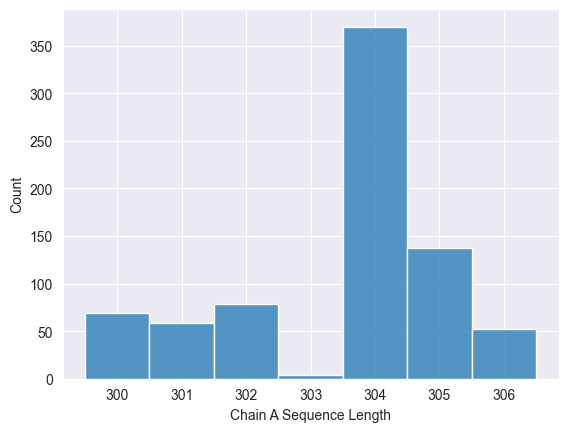

Chain A Sequence Length Values: [300, 301, 302, 303, 304, 305, 306], Total: 7


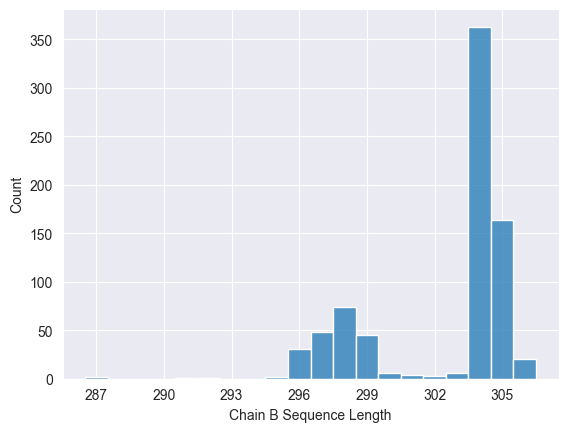

Chain B Sequence Length Values: [287, 291, 292, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306], Total: 15


In [10]:
# Protein Chain A and Chain B Sequence Length for SARS-CoV-2 Mpro
sns.histplot(df_train_X['Chain A Sequence Length'], discrete=True)
plt.show()
print(f"Chain A Sequence Length Values: {sorted(df_train_X['Chain A Sequence Length'].unique().tolist())}, "
      f"Total: {len(df_train_X['Chain A Sequence Length'].unique())}")

sns.histplot(df_train_X['Chain B Sequence Length'], discrete=True)
plt.xticks(range(min(df_train_X['Chain B Sequence Length']), max(df_train_X['Chain B Sequence Length']) + 1, 3))
plt.show()
print(f"Chain B Sequence Length Values: {sorted(df_train_X['Chain B Sequence Length'].unique().tolist())}, "
      f"Total: {len(df_train_X['Chain B Sequence Length'].unique())}")

In [11]:
# Look at unique Chain A Sequences for each Sequence Length
for seq_len in sorted(df_train_X['Chain A Sequence Length'].unique().tolist()):
    print(f"Chain A Sequence Length: {seq_len}")
    df_filtered = df_train_X[df_train_X['Chain A Sequence Length'] == seq_len]

    unique_vals = df_filtered['Chain A Sequence'].unique()
    unique_indices = {val: df_filtered.index[df_filtered['Chain A Sequence'] == val].tolist() for val in unique_vals}
    print(unique_indices)

Chain A Sequence Length: 300
{'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQC': [3, 4, 11, 48, 57, 67, 69, 104, 108, 110, 117, 120, 128, 131, 136, 145, 148, 168, 192, 221, 228, 240, 249, 251, 256, 259, 261, 264, 281, 293, 322, 335, 352, 369, 373, 381, 393, 410, 412, 416, 434, 437, 471, 485, 492, 495, 527, 531, 565, 571, 583, 595, 617, 628, 657, 662, 675, 683, 689, 697, 698, 700, 702, 705, 713, 757], 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDIQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQC': [247, 432], 'SGFRKMAFPSGKVEGCMVQVTCGTTT

### Test Data

In [12]:
# Add column with Chain A and Chain B Sequence Length
df_test_X['Chain A Sequence Length'] = df_test_X['Chain A Sequence'].apply(len)
df_test_X['Chain B Sequence Length'] = df_test_X['Chain B Sequence'].apply(len)

In [14]:
df_test_X_sars = df_test_X[df_test_X['Protein Label'] == 'SARS-CoV-2 Mpro']
df_test_X_mers = df_test_X[df_test_X['Protein Label'] == 'MERS-CoV Mpro']

print("-------Protein Label-------")
print(f"SARS-CoV-2 Mpro Count: {len(df_test_X_sars)}")
print(f"MERS-CoV Mpro Count:   {len(df_test_X_mers)}")

print("-------Protein-------")
print(f"Unique Chain A Sequences (SARS-CoV-2 Mpro): {len(df_test_X_sars['Chain A Sequence'].unique())}")
print(f"Unique Chain B Sequences (SARS-CoV-2 Mpro): {len(df_test_X_sars['Chain B Sequence'].unique())}")
print(f"Unique Chain A Sequences (MERS-CoV Mpro)  : {len(df_test_X_mers['Chain A Sequence'].unique())}")
print(f"Unique Chain B Sequences (MERS-CoV Mpro)  : {len(df_test_X_mers['Chain B Sequence'].unique())}")
print(f"Identical Chain A and B Sequence Count (SARS-CoV-2 Mpro): {len(df_test_X_sars[df_test_X_sars['Chain A Sequence'] == df_test_X_sars['Chain B Sequence']])}")
print(f"Identical Chain A and B Sequence Count (MERS-CoV Mpro)  : {len(df_test_X_mers[df_test_X_mers['Chain A Sequence'] == df_test_X_mers['Chain B Sequence']])}")

print("-------Ligand-------")
print(f"Unique CXSMILES: {len(df_test_X['CXSMILES'].unique())}")

-------Protein Label-------
SARS-CoV-2 Mpro Count: 98
MERS-CoV Mpro Count:   97
-------Protein-------
Unique Chain A Sequences (SARS-CoV-2 Mpro): 3
Unique Chain B Sequences (SARS-CoV-2 Mpro): 5
Unique Chain A Sequences (MERS-CoV Mpro)  : 2
Unique Chain B Sequences (MERS-CoV Mpro)  : 3
Identical Chain A and B Sequence Count (SARS-CoV-2 Mpro): 83
Identical Chain A and B Sequence Count (MERS-CoV Mpro)  : 84
-------Ligand-------
Unique CXSMILES: 161


In [19]:
df_test_X

,Chain A Sequence,Chain B Sequence,CXSMILES,Protein Label,Chain A Sequence Length,Chain B Sequence Length
0,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,MERS-CoV Mpro,303,303
1,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cc1,MERS-CoV Mpro,303,303
2,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SARS-CoV-2 Mpro,305,305
3,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,MERS-CoV Mpro,303,303
4,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1ccnnc1)C(=O)N(c1c...,MERS-CoV Mpro,303,303
...,...,...,...,...,...,...
190,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CNS(=O)(=O)OCC(=O)N[C@@H](C)c1cc(Cl)cc(-c2ccc(...,SARS-CoV-2 Mpro,305,305
191,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SARS-CoV-2 Mpro,305,305
192,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,O=C(Cc1cncc2ccccc12)NCc1cccc(Cl)c1,MERS-CoV Mpro,303,303
193,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,SARS-CoV-2 Mpro,305,305


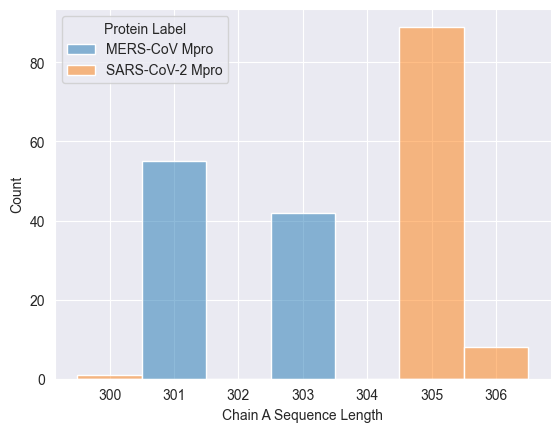

Chain A Sequence Length Values: [300, 301, 303, 305, 306]


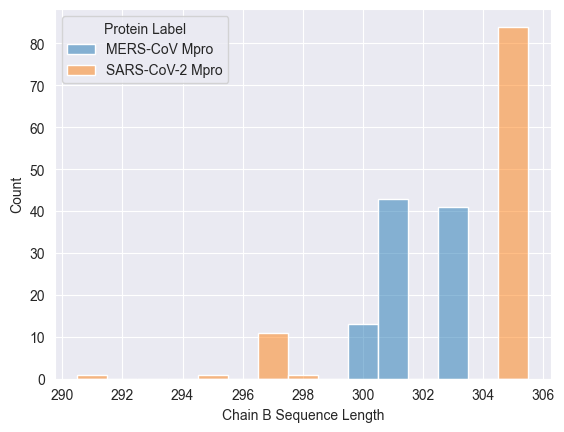

Chain B Sequence Length Values: [291, 295, 297, 298, 300, 301, 303, 305]


In [22]:
# Protein Chain A and Chain B Sequence Length for SARS-CoV-2 Mpro and MERS-CoV Mpro
sns.histplot(data=df_test_X, x='Chain A Sequence Length', hue='Protein Label', discrete=True)
plt.show()
print(f"Chain A Sequence Length Values: {sorted(df_test_X['Chain A Sequence Length'].unique().tolist())}")

sns.histplot(data=df_test_X, x='Chain B Sequence Length', hue='Protein Label', discrete=True)
plt.show()
print(f"Chain B Sequence Length Values: {sorted(df_test_X['Chain B Sequence Length'].unique().tolist())}")

### Sequence Alignment of AA Chains

In [15]:
MERS_REF_A = "SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIM"

MERS_REF_B = "SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIM"

SARS_REF_A = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"

SARS_REF_B = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTF"

#### Train Data

In [16]:
# Reference Sequence A for SARS-CoV-2 Mpro (provided by polaris)
chainA_train_unique = df_train_X.sort_values(by='Chain A Sequence', key=lambda x: x.str.len())['Chain A Sequence'].unique()

for i, chain in enumerate(chainA_train_unique):
    alignments = pairwise2.align.globalxx(SARS_REF_A, chain)
    alignment = alignments[0]   # Get first alignment

    indices = df_train_X[df_train_X['Chain A Sequence'] == chain].index.tolist()
    print(f"Chain A Sequence {i}, Length: {len(chain)}, Total Sequences: {len(indices)}")
    print(format_alignment(*alignment))

Chain A Sequence 0, Length: 300, Total Sequences: 66
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||      
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQC------
  Score=300

Chain A Seque

In [17]:
# Reference Sequence B for SARS-CoV-2 Mpro (provided by polaris)
chainB_train_unique = df_train_X.sort_values(by='Chain B Sequence', key=lambda x: x.str.len())['Chain B Sequence'].unique()

for i, chain in enumerate(chainB_train_unique):
    alignments = pairwise2.align.globalxx(SARS_REF_B, chain)
    alignment = alignments[0]   # Get first alignment

    indices = df_train_X[df_train_X['Chain B Sequence'] == chain].index.tolist()
    print(f"Chain B Sequence {i}, Length: {len(chain)}, Total Sequences: {len(indices)}")
    print(format_alignment(*alignment))

Chain B Sequence 0, Length: 287, Total Sequences: 2
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTF
||||||||||||||||||||||||||||||||||||||||||        |  ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHV--------I--SNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTF
  Score=287

Chain B Sequence 1, Length: 291, Total Se

In [18]:
# Align reference A and B Sequences (SARS-CoV-2 Mpro)
alignments = pairwise2.align.globalxx(SARS_REF_A, SARS_REF_B)
for alignment in alignments:
  # Get first alignment
    print(format_alignment(*alignment))

SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ
||||||||||||||||||||||||||||||||||||||||||||        ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--------NYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTF-
  Score=297

SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNF

In [10]:
# Alignment of Chain A Sequences
chainA_train_unique = df_train_X['Chain A Sequence'].unique()

for i in range(len(chainA_train_unique)-1):
    for j in range(i, len(chainA_train_unique)):
        if i != j:
            if len(chainA_train_unique[i]) == len(chainA_train_unique[j]):
                alignments = pairwise2.align.globalxx(chainA_train_unique[i], chainA_train_unique[j])
                alignment = alignments[0]   # Get first alignment
                print(f"Chain A Sequence {i} vs Sequence {j}, Length: {len(chainA_train_unique[i])}")
                print(f"Sequence {i} Length: {len(chainA_train_unique[i])}, Sequence {j} Length: {len(chainA_train_unique[j])}")
                print(format_alignment(*alignment))

Chain A Sequence 0 vs Sequence 5, Length: 304
Sequence 0 Length: 304, Sequence 5 Length: 304
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVT-
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPG-TFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFD

In [80]:
# Alignment of Chain B Sequences
chainB_train_unique = df_train_X['Chain B Sequence'].unique()

for i in range(len(chainB_train_unique)-1):
    for j in range(i, len(chainB_train_unique)):
        if i != j:
            alignments = pairwise2.align.globalxx(chainB_train_unique[i], chainB_train_unique[j])
            alignment = alignments[0]   # Get first alignment
            print(f"Chain B Sequence {i} vs Sequence {j}")
            print(f"Sequence {i} Length: {len(chainB_train_unique[i])}, Sequence {j} Length: {len(chainB_train_unique[j])}")
            print(format_alignment(*alignment))

Chain B Sequence 0 vs Sequence 1
Sequence 0 Length: 304, Sequence 1 Length: 302
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVT-
|||||||||||||||||||||||||||||||||||||||||||   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVI---EDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTF
  

#### Test Data

In [24]:
# Reference Sequence A for SARS-CoV-2 Mpro (provided by polaris)
df_test_X_sars = df_test_X[df_test_X['Protein Label'] == 'SARS-CoV-2 Mpro']

chainA_sars_test_unique = df_test_X_sars.sort_values(by='Chain A Sequence', key=lambda x: x.str.len())['Chain A Sequence'].unique()

for i, chain in enumerate(chainA_sars_test_unique):
    alignments = pairwise2.align.globalxx(SARS_REF_A, chain)
    alignment = alignments[0]   # Get first alignment

    indices = df_test_X_sars[df_test_X_sars['Chain A Sequence'] == chain].index.tolist()
    print(f"Chain A Sequence {i}, Length: {len(chain)}, Total Sequences: {len(indices)}")
    print(format_alignment(*alignment))

Chain A Sequence 0, Length: 300, Total Sequences: 1
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||      
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQC------
  Score=300

Chain A Sequen

In [25]:
# Reference Sequence B for SARS-CoV-2 Mpro (provided by polaris)
chainB_sars_test_unique = df_test_X_sars.sort_values(by='Chain B Sequence', key=lambda x: x.str.len())['Chain B Sequence'].unique()

for i, chain in enumerate(chainB_sars_test_unique):
    alignments = pairwise2.align.globalxx(SARS_REF_B, chain)
    alignment = alignments[0]   # Get first alignment

    indices = df_test_X_sars[df_test_X_sars['Chain B Sequence'] == chain].index.tolist()
    print(f"Chain B Sequence {i}, Length: {len(chain)}, Total Sequences: {len(indices)}")
    print(format_alignment(*alignment))

Chain B Sequence 0, Length: 291, Total Sequences: 1
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTF
||||||||||||||||||||||||||||||||||||||||||| ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||     
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVI-NYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQC-----
  Score=291

Chain B Sequence 1, Length: 295, Total Se

In [26]:
# Align with reference Sequence A for MERS-CoV-2 Mpro (provided by polaris)
df_test_X_mers = df_test_X[df_test_X['Protein Label'] == 'MERS-CoV Mpro']

chainA_mers_test_unique = df_test_X_mers.sort_values(by='Chain A Sequence', key=lambda x: x.str.len())['Chain A Sequence'].unique()

for i, chain in enumerate(chainA_mers_test_unique):
    alignments = pairwise2.align.globalxx(MERS_REF_A, chain)
    alignment = alignments[0]   # Get first alignment

    indices = df_test_X_mers[df_test_X_mers['Chain A Sequence'] == chain].index.tolist()
    print(f"Chain A Sequence {i}, Length: {len(chain)}, Total Sequences: {len(indices)}")
    print(format_alignment(*alignment))

Chain A Sequence 0, Length: 301, Total Sequences: 55
SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIM
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIM
  Score=301

Chain A Sequence 1, Length: 

In [36]:
# Align with reference Sequence B for MERS-CoV-2 Mpro (provided by polaris)
chainB_mers_test_unique = df_test_X_mers.sort_values(by='Chain B Sequence', key=lambda x: x.str.len())['Chain B Sequence'].unique()

for i, chain in enumerate(chainB_mers_test_unique):
    alignments = pairwise2.align.globalxx(MERS_REF_B, chain)
    alignment = alignments[0]   # Get first alignment

    indices = df_test_X_mers[df_test_X_mers['Chain B Sequence'] == chain].index.tolist()
    print(f"Chain B Sequence {i}, Length: {len(chain)}, Total Sequences: {len(indices)}")
    print(format_alignment(*alignment))

Chain B Sequence 0, Length: 300, Total Sequences: 13
SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIM
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 
SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQI-
  Score=300

Chain B Sequence 1, Length: 

In [37]:
# Align reference A and B Sequences (MERS-CoV Mpro)
alignments = pairwise2.align.globalxx(MERS_REF_A, MERS_REF_B)
for alignment in alignments:
  # Get first alignment
    print(format_alignment(*alignment))

SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIM
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIM
  Score=301



In [41]:
# Align Chain A Sequences of SARS-CoV-2 Mpro for train and test
chainA_train_unique = df_train_X['Chain A Sequence'].unique()
chainA_test_unique = df_test_X_sars['Chain A Sequence'].unique()

for i, chain_test in enumerate(chainA_test_unique):
    for j, chain_train in enumerate(chainA_train_unique):
        if len(chain_test) == len(chain_train):
            alignments = pairwise2.align.globalxx(chain_test, chain_train)
            alignment = alignments[0]   # Get first alignment
            print(f"Chain A Test Sequence {i} vs Train Sequence {j}")
            print(f"Sequence Test {i} Length: {len(chainA_test_unique[i])}, Sequence Train {j} Length: {len(chainA_train_unique[j])}")
            print(format_alignment(*alignment))

Chain A Test Sequence 0 vs Train Sequence 1
Sequence Test 0 Length: 305, Sequence Train 1 Length: 305
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTF
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSAL

### Ligands

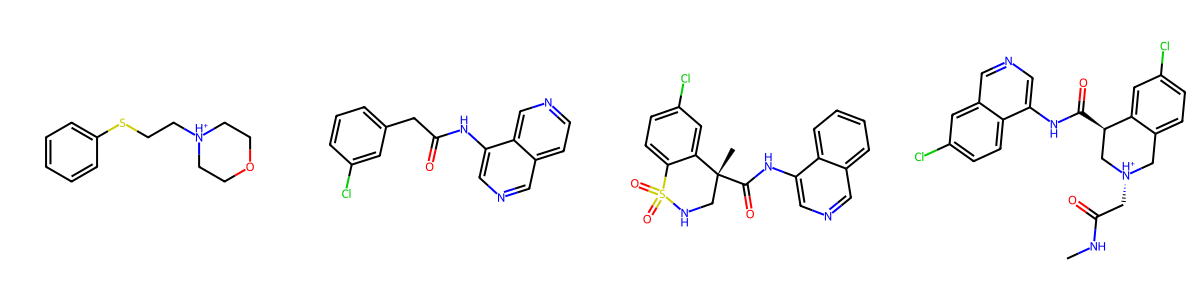

In [34]:
train_y = train.y
train_mols = [Chem.MolFromSmiles(df_train_X['CXSMILES'].iloc[i]) for i in range(len(df_train_X))]
test_mols = [Chem.MolFromSmiles(df_test_X['CXSMILES'].iloc[i]) for i in range(len(df_test_X))]

# First 4 ligands in train set
Draw.MolsToGridImage(train_mols[:4], molsPerRow=4, subImgSize=(300, 300))

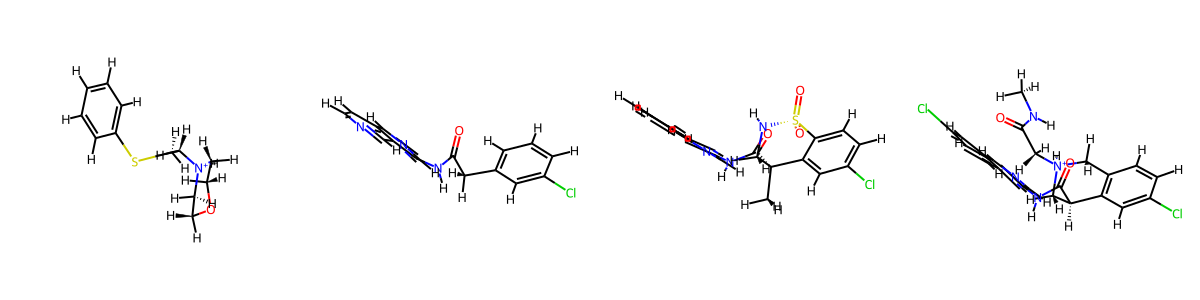

In [35]:
# First 4 ligands in train set in correct pose for docking
Draw.MolsToGridImage(train_y[:4], molsPerRow=4, subImgSize=(300, 300))

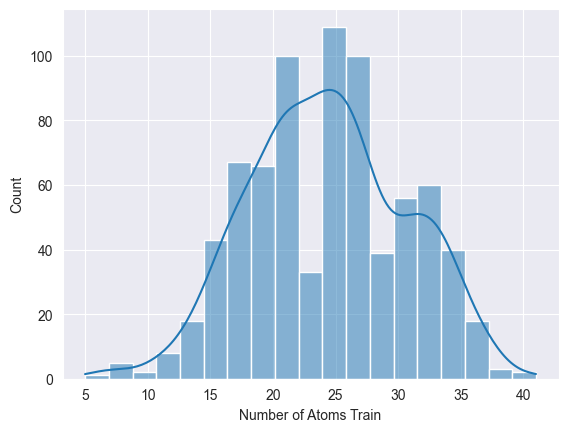

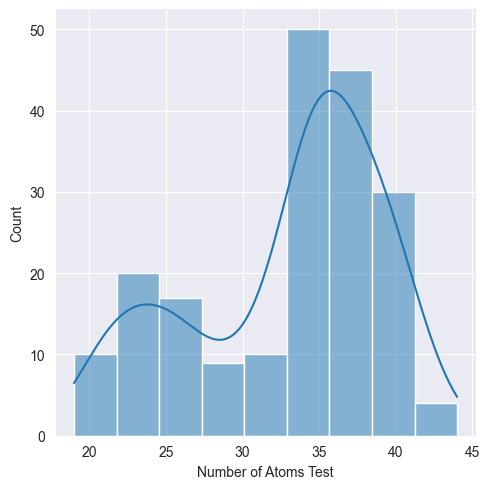

In [36]:
# Number of atoms in ligand
sns.histplot(data=pd.DataFrame({"Number of Atoms Train":  [mol.GetNumAtoms() for mol in train_mols]}), x="Number of Atoms Train", kde=True)
plt.show()

sns.displot(data=pd.DataFrame({"Number of Atoms Test":  [mol.GetNumAtoms() for mol in test_mols]}), x="Number of Atoms Test", kde=True)
plt.show()

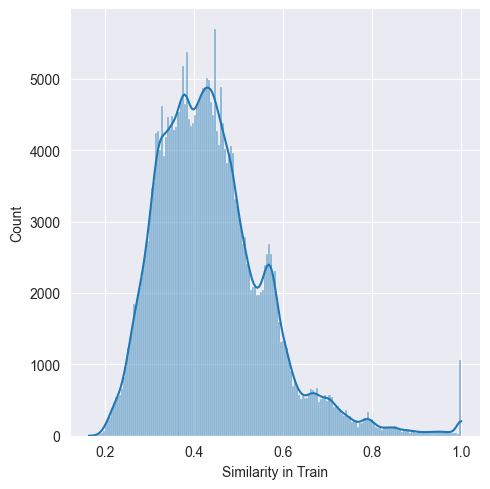

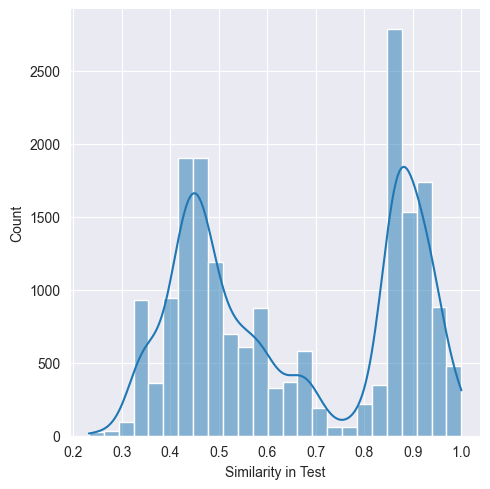

In [37]:
# Similarity within train and test set
train_fps = [FingerprintMols.FingerprintMol(mol) for mol in train_mols]
test_fps = [FingerprintMols.FingerprintMol(mol) for mol in test_mols]

train_sim = []
for i in range(len(train_fps)-1):
    for j in range(i, len(train_fps)):
        train_sim.append(DataStructs.TanimotoSimilarity(train_fps[i], train_fps[j]))

sns.displot(data=pd.DataFrame({"Similarity in Train": train_sim}), x="Similarity in Train", kde=True)
plt.show()

test_sim = []
for i in range(len(test_fps)-1):
    for j in range(i, len(test_fps)):
        test_sim.append(DataStructs.TanimotoSimilarity(test_fps[i], test_fps[j]))

sns.displot(data=pd.DataFrame({"Similarity in Test": test_sim}), x="Similarity in Test", kde=True)
plt.show()

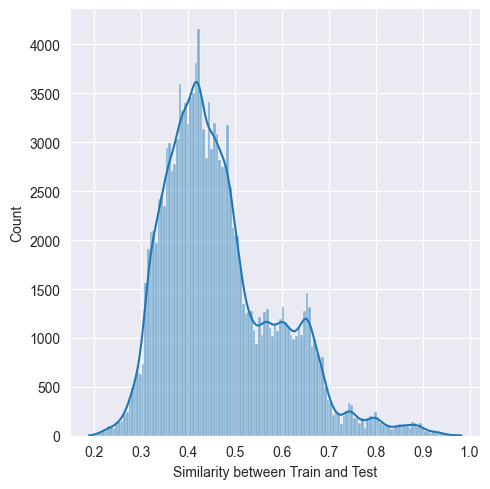

In [38]:
# Similarity between train and test
sim = []
for i in range(len(train_fps)):
    for j in range(len(test_fps)):
        sim.append(DataStructs.TanimotoSimilarity(train_fps[i], test_fps[j]))

sns.displot(data=pd.DataFrame({"Similarity between Train and Test": sim}), x="Similarity between Train and Test", kde=True)
plt.show()

### Additional data for training

The dataset of the competition provides additional data for training: `Complex Structure` and `Protein Structure`.

In [4]:
datapoint = competition[0]

type(datapoint["Complex Structure"]), type(datapoint["Protein Structure"])

(biotite.structure.AtomArray, biotite.structure.AtomArray)

**Complex Structure**

In [5]:
# Write complex structure to PDB file and visualize it
complex_file = "complex.pdb"
pdb_file = fastpdb.PDBFile()
pdb_file.set_structure(datapoint["Complex Structure"])
pdb_file.write(complex_file)

view = nv.show_file(complex_file)
view

NGLWidget()

**Protein Structure**

In [6]:
# Write protein structure to PDB file and visualize it
protein_file = "protein.pdb"
pdb_file = fastpdb.PDBFile()
pdb_file.set_structure(datapoint["Protein Structure"])
pdb_file.write(protein_file)

view = nv.show_file(protein_file)
view

NGLWidget()